## Description ##

This notebook demonstrates how to upload historical data from OSM using Ohsome API.  The documention of API can be found here - https://docs.ohsome.org/ohsome-api/v1/endpoints.html#elements-extraction 

#### Steps ####
 - First attempt to download roads using a given bbox and month
 - Loop. Number of roads per every month
 - Demonstration of some statistics
 

In [1]:
import requests
import json
import geopandas as gpd
import datetime
import pandas as pd


## First attempt ##

For this example I used bbox as a location identifier, one month as a time period. The target elements are all kind of roads.

In [3]:
URL = "https://api.ohsome.org/v1/elements/geometry"
data = {
    "bboxes": "47.544193267822, 29.395187700478,47.65474319458,29.514915317541,",
    "time": "2021-12-01",
    "filter": "highway=* and type:way",
}
response = requests.post(URL, data=data)

In [4]:
with open("roads-2021-12-01.json", "w") as f:
    json.dump(response.json(), f)

In [6]:
gdf_2112 = gpd.read_file("roads-2021-12-01.json")

In [8]:
gdf_2112.columns = ["osmid", "timestamp", "the_geom"]

In [9]:
gdf_2112.head()

,osmid,timestamp,the_geom
0,way/86525968,2021-12-01 00:00:00+00:00,"MULTILINESTRING ((47.65474 29.51386, 47.65471 ..."
1,way/362221767,2021-12-01 00:00:00+00:00,"LINESTRING (47.64185 29.39519, 47.64170 29.395..."
2,way/112349408,2021-12-01 00:00:00+00:00,"LINESTRING (47.64115 29.39914, 47.63990 29.39924)"
3,way/112447095,2021-12-01 00:00:00+00:00,"LINESTRING (47.64034 29.39792, 47.64042 29.398..."
4,way/112447113,2021-12-01 00:00:00+00:00,"LINESTRING (47.64273 29.39678, 47.64282 29.396..."


In [15]:
gdf_2112 = gpd.GeoDataFrame(gdf_2112, crs='epsg:4326', geometry='the_geom')

<Axes: >

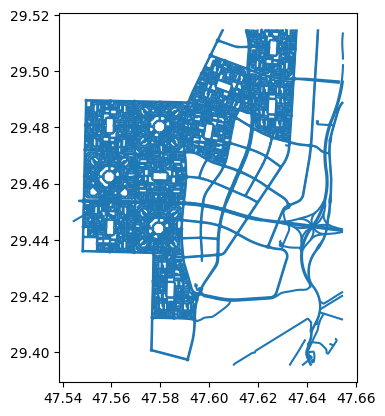

In [16]:
gdf_2112.plot()

## Loop ##

This part aggregatres number of road segments for every month within given interval

In [31]:
min_date = datetime.datetime.strptime("2021-01-01", "%Y-%m-%d")
max_date = datetime.datetime.strptime("2022-06-01", "%Y-%m-%d")

In [33]:
gdf_all = gpd.GeoDataFrame()

for d in pd.date_range(min_date, max_date, freq="MS"):

    try:
        URL = "https://api.ohsome.org/v1/elements/geometry"
        data = {
            "bboxes": "47.544193267822, 29.395187700478,47.65474319458,29.514915317541",

            "time": f"{d.date()}",
            "filter": "highway=* and type:way",
        }
        response = requests.post(URL, data=data)
        size = len(response.json()['features'])
        
        print (f'for month {d}, successfuly downloaded {size} elements')
        
        with open("roads.geojson", "w") as f:
            json.dump(response.json(), f)
        
    except:
         print (f'for month {d} error')

    gdf_2101 = gpd.read_file("roads.geojson")
    gdf_2101.columns = ["osmid", "timestamp", "the_geom"]
    sd = "".join(str(d.date()).split("-"))
    
    gdf_all = pd.concat([gdf_all,gdf_2101])

for month 2021-01-01 00:00:00, successfuly downloaded 887 elements
for month 2021-02-01 00:00:00, successfuly downloaded 887 elements
for month 2021-03-01 00:00:00, successfuly downloaded 887 elements
for month 2021-04-01 00:00:00, successfuly downloaded 887 elements
for month 2021-05-01 00:00:00, successfuly downloaded 931 elements
for month 2021-06-01 00:00:00, successfuly downloaded 954 elements
for month 2021-07-01 00:00:00, successfuly downloaded 974 elements
for month 2021-08-01 00:00:00, successfuly downloaded 1123 elements
for month 2021-09-01 00:00:00, successfuly downloaded 2027 elements
for month 2021-10-01 00:00:00, successfuly downloaded 5147 elements
for month 2021-11-01 00:00:00, successfuly downloaded 5146 elements
for month 2021-12-01 00:00:00, successfuly downloaded 5155 elements
for month 2022-01-01 00:00:00, successfuly downloaded 5160 elements
for month 2022-02-01 00:00:00, successfuly downloaded 5160 elements
for month 2022-03-01 00:00:00, successfuly downloaded 5

In [34]:
gdf_all.shape

(55992, 3)

### Explicitly declare crs and geomtery column

In [39]:
gdf_all = gdf_all.set_geometry('the_geom')

In [41]:
gdf_all.crs = 'epsg:4326'

## Examples of some monthly statistics ##

In [48]:
## number of roads
gdf_all.groupby('timestamp')['osmid'].count()

timestamp
2021-01-01 00:00:00+00:00     887
2021-02-01 00:00:00+00:00     887
2021-03-01 00:00:00+00:00     887
2021-04-01 00:00:00+00:00     887
2021-05-01 00:00:00+00:00     931
2021-06-01 00:00:00+00:00     954
2021-07-01 00:00:00+00:00     974
2021-08-01 00:00:00+00:00    1123
2021-09-01 00:00:00+00:00    2027
2021-10-01 00:00:00+00:00    5147
2021-11-01 00:00:00+00:00    5146
2021-12-01 00:00:00+00:00    5155
2022-01-01 00:00:00+00:00    5160
2022-02-01 00:00:00+00:00    5160
2022-03-01 00:00:00+00:00    5160
2022-04-01 00:00:00+00:00    5160
2022-05-01 00:00:00+00:00    5174
2022-06-01 00:00:00+00:00    5173
Name: osmid, dtype: int64

In [42]:
gdf_all['length'] = gdf_all['the_geom'].to_crs('epsg:32637').length

In [46]:
##Km of existing roads 

gdf_all.groupby('timestamp')['length'].sum()/1000

timestamp
2021-01-01 00:00:00+00:00     417.658176
2021-02-01 00:00:00+00:00     417.658176
2021-03-01 00:00:00+00:00     417.658176
2021-04-01 00:00:00+00:00     417.658176
2021-05-01 00:00:00+00:00     486.683324
2021-06-01 00:00:00+00:00     499.469568
2021-07-01 00:00:00+00:00     511.169812
2021-08-01 00:00:00+00:00     543.246802
2021-09-01 00:00:00+00:00     653.082852
2021-10-01 00:00:00+00:00    1205.234321
2021-11-01 00:00:00+00:00    1205.650968
2021-12-01 00:00:00+00:00    1210.724426
2022-01-01 00:00:00+00:00    1210.830587
2022-02-01 00:00:00+00:00    1210.830587
2022-03-01 00:00:00+00:00    1210.830587
2022-04-01 00:00:00+00:00    1210.830587
2022-05-01 00:00:00+00:00    1210.369180
2022-06-01 00:00:00+00:00    1210.361758
Name: length, dtype: float64